# Here I will try to make a GA that find network structures for toy problems

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data

import math

import matplotlib.pyplot as plt
%matplotlib inline

import time
import sys

In [141]:
!pwd

/home/samuel/PycharmProjects/exjobb


## A PyTorch nn.Module class that constructs networks from encodings

In [2]:
# I think it would be good to use blocks. Maybe check the paper about Cells
class geno2pheno(nn.Module):
    def __init__(self, genome, nin, nout):
        super(geno2pheno, self).__init__()
        # build layers from genome encoding
        
        n_in = nin
        k = 1
        fw_map = {}
        
        # stupid loop but I want to know how deep the net will be
        nbr_h = 0
        for l in genome['layers']:
            if l['active']:
                nbr_h += 1
                
        for l in genome['layers']:
            if l['active']:
                # Add the active layers in the encoding to the model 
                key = str(k)
                setattr(self, key, nn.Linear(n_in, genome['n_nodes']))
                
                # We are on the last hidden layer, so we will not have any skipps here
                if k == nbr_h:
                    fw_map[key] = ['out']
                    # at current setting n_in is same for all but first layer
                    n_in = genome['n_nodes']
                    break
                    
                fw_map[key] = [str(k + 1)]
                
                # Add skips to the fw_map. If they are to long, sent them to output layer
                if l['skip'] >= nbr_h - k:
                    fw_map[key].append('out')
                elif l['skip'] > 0:
                    fw_map[key].append(str(k + 1 + l['skip']))
                
                k += 1
                # Again, tis is same for all but first layer
                n_in = genome['n_nodes']
                
        # Since I force the first layer to be active this will mean that we never get a perceptron
        # Is that an issue at all?
        setattr(self, 'out', nn.Linear(n_in, nout))
        
        # fw_scheme is a dict containing to which layers each layer is sending its output
        # This will fail if we have non-forward connections
        self.fw_scheme = fw_map
        print(self.fw_scheme)
        
    def forward(self, x):
        pr=False
        X = dict()
        X['1'] = [x]
        if pr:
            print(self.fw_scheme)
        
        k = 1
        # for idx in range(1, self.nbr_h + 1):
        while hasattr(self, str(k)):
            # pass trough all layers except the output layer
            key = str(k)
            if pr:
                print(key, getattr(self, key))
            
            # we might want to concat instead of sum, then we need to modify input_size in __init__
            temp_x = sum(X[key])
            temp_out = torch.tanh(getattr(self, key)(temp_x))
            # this seem to work when doing the list thing with x
            for target in self.fw_scheme[key]:
                if target in X:
                    X[target].append(temp_out)
                else: 
                    X[target] = [temp_out]
                    
            k += 1

        # Identity as output function since we do regression
        # Add support for other types od problems problems
        temp_x = sum(X['out'])
        out = getattr(self, 'out')(temp_x)
        if pr: 
            print(getattr(self, 'out'))
            
        #print('\n my fw_pass', X)
        return out

## get_net() and get_pop() creates random encodings for networks given a framework

In [4]:
def get_net(depth, n_frame, l_frame):
    genes = []
    n_nodes = n_frame['n_nodes'][np.random.randint(len(n_frame['n_nodes']))]
    
    for i in range(depth):
        gene_encoding = {
            "active": l_frame['active'][np.random.randint(len(l_frame['active']))],
            "skip": int(np.round(np.random.gamma(1, scale=1/2)))
        }
        if i == 0:
            # no empty nets
            gene_encoding['active'] = True
        genes.append(gene_encoding)
        
    genome_encoding = {
        "n_nodes": n_nodes,
        "layers": genes
    }
    
    return genome_encoding

In [5]:
# genome = network
# gene = layer
def get_pop(pop_size, net_depth, n_frame, l_frame):
    pop = []
    for _ in range(pop_size):
        genome = get_net(net_depth, n_frame, l_frame)
        pop.append(genome)
        
    return pop

## trainer() trains given network to fit to given objective funtion, just to see that something actually happens

In [115]:
# Stole most of this online, should be improved uppon
def trainer(net, epochs, noise, objective='x2'):
    torch.manual_seed(1)    # reproducible

    x = torch.unsqueeze(torch.linspace(-1, 1, 20), dim=1)  # x data (tensor), shape=(100, 1)
    
    if objective == 'x2':
        y = x.pow(2) + noise * torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)
    elif objective == 'sinx':
        y = torch.sin(3*3.14*x) + noise * torch.rand(x.size())          # noisy y data (tensor), shape=(100, 1)


    # torch can only train on Variable, so convert them to Variable
    x, y = Variable(x), Variable(y)
    # does this help me??
    torch.autograd.set_detect_anomaly(True)

    print(net)  # net architecture

    optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
    loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

    # train the network
    t0 = time.perf_counter()
    
    for t in range(epochs):
        prediction = net(x)     # input x and predict based on x
        loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients

    loss = loss.data.numpy()
    tr_time = time.perf_counter() - t0
    print(tr_time, "seconds to train")
    
    # view data
    plt.figure(figsize=(10,4))
    plt.scatter(x.data.numpy(), y.data.numpy(), color = "orange")
    plt.plot(x.data.numpy(), prediction.data.numpy(), 'g-', lw=3)

    plt.title('Regression Analysis')
    plt.text(1.0, 0, 'Loss = %.4f' % loss,
                fontdict={'size': 24, 'color':  'red'})
    plt.show()
    
    return loss, tr_time

## Script that sets framework and some hyper-parameters. Then generates, briefly trains and evaluates a population. Further I want to implement a GA to find, suitable topologies for a given problem (DRL?) and increase the number of hyper-parameters in the framework.

In [69]:
max_width = 8
max_depth = 8

# include much more hyperparameters into the frameworks

# atm we create only networks with nn.linear() layers. The only fun part is that I have
# enabled layers to have skip connections (resdual layers?).
layers = {}
net_framework = {
    "n_nodes": [2**i for i in range(1, int(math.log(max_width, 2)) + 1)],
    "layers": {},
}

layer_framework = {
    "active": [True, False],
    "skip": ['skip ~ gamma(1, 1/2)']    # skip is assigned in get_net() by grawing numbers from a gamma distribution
}

print('This is the framework from which networks are randomly constructed:\n', net_framework, '\n')
print('This is the framework from which layers are randomly constructed:\n', layer_framework, '\n')
# sys.exit()

start_time = time.perf_counter()

pop_size = 5
pop = get_pop(pop_size, max_width, net_framework, layer_framework)
nin = 1
nout = 1

eps = 200
noise  = 0.3
x = np.ones(nin)
x = torch.Tensor(x)

print('Here is the networks in the population, dicts shows where each layer sends its output in each network')
pheno_pop = []
for g in pop:
    pheno = geno2pheno(g, nin, nout)
    pheno.forward(x)
    pheno_pop.append(pheno)
    
#sys.exit()

best = (0, 1000)
for p in pheno_pop:
    loss, t = trainer(p, eps, noise, objective='x2')
    score = loss * t
    print('score measued as training time * loss: ', score)
    
print('\nAll this took ', time.perf_counter() - start_time, ' seconds')
    
# now we have a performance estimation for the network
# so appliyng a GA to this should be doable
    

This is the framework from which networks are randomly constructed:
 {'n_nodes': [2, 4, 8], 'layers': {}} 

This is the framework from which layers are randomly constructed:
 {'active': [True, False], 'skip': ['skip ~ gamma(1, 1/2)']} 



NameError: name 'get_pop' is not defined

## build, train and evaluate a model given a HyperMapper scenario of parameters

In [132]:
def ex_scenario():
    max_width = 8
    max_depth = 4

    X = {
        'n_nodes' : 16,    # range from 0 to max width
        # Loop through max_depth to set for each i
        'active_0' : 1,
        'skip_0' : 0,
        'active_1' : 1,   # 0/1
        'skip_1' : 0,     # int
        'active_2' : 1,
        'skip_2' : 0,
        'active_3' : 1,
        'skip_3' : 0,
        'active_4' : 1,
        'skip_4' : 0
    }
    return X

In [133]:
### OBSOLATE, CHECK IN MY_HYPERMAPPER FOR BETTER VERSION ###
# I think it would be good to use blocks. Maybe check the paper about Cells
class json2pheno(nn.Module):
    def __init__(self, json, nin, nout):
        super(json2pheno, self).__init__()
        # build layers from genome encoding
        
        n_in = nin
        fw_map = {}
        
        # stupid loop but I want to know how deep the net will be
        active_list = []
        for param in json.keys():
            if param[:-2] == 'active' and json[param] == 1:
                active_list.append(param[-1])
                
        # Add the active layers in the encoding to the model
        for new_i, old_i in enumerate(active_list):
            key = str(new_i)
            setattr(self, key, nn.Linear(n_in, json['n_nodes']))

            # We are on the last hidden layer, so we will not have any skipps here
            if new_i == len(active_list) - 1:
                fw_map[key] = ['out']
                # at current setting n_in is same for all but first layer
                n_in = json['n_nodes']
                break

            fw_map[key] = [str(new_i + 1)]

            # Add skips to the fw_map. If they are to long, sent them to output layer                
            target = json['skip_' + str(old_i)] + new_i + 1
            if target >= len(active_list):
                fw_map[key].append('out')
            elif target > new_i + 1:
                fw_map[key].append(str(target))

            # Again, this is same for all but first layer
            n_in = json['n_nodes']
            
                
        setattr(self, 'out', nn.Linear(n_in, nout))
        
        # fw_scheme is a dict containing to which layers each layer is sending its output
        # This will fail if we have non-forward connections
        self.fw_scheme = fw_map
        print(self.fw_scheme)
        
    def forward(self, x):
        k = 0
        X = dict()
        X[str(k)] = [x]
        while hasattr(self, str(k)):
            # pass trough all layers except the output layer
            key = str(k)
           
            # we might want to concat instead of sum, then we need to modify input_size in __init__
            temp_x = sum(X[key])
            temp_out = torch.tanh(getattr(self, key)(temp_x))
            # this seem to work when doing the list thing with x
            for target in self.fw_scheme[key]:
                if target in X:
                    X[target].append(temp_out)
                else: 
                    X[target] = [temp_out]
                    
            k += 1

        # if k = 0 we have no active layers and a perceptron model
        if k:
            temp_x = sum(X['out'])
        else:
            temp_x = x
            
        # Identity as output function since we do regression
        # Add support for other types od problems problems
        out = getattr(self, 'out')(temp_x)            
        return out

## Build, train and evaluate a model given the scenario

In [139]:
def NAS_function(X):
    
    nin = 1
    nout = 1

    eps = 5000
    noise  = 0.3
    my_net = json2pheno(X, nin, nout)

    loss, t = trainer(my_net, eps, noise, objective='sinx')
    score = loss * t
    return score

X =  {'n_nodes': 16, 'active_0': 1, 'skip_0': 0, 'active_1': 1, 'skip_1': 0, 'active_2': 1, 'skip_2': 0, 'active_3': 1, 'skip_3': 0, 'active_4': 1, 'skip_4': 0}
{'0': ['1'], '1': ['2'], '2': ['3'], '3': ['4'], '4': ['out']}
json2pheno(
  (0): Linear(in_features=1, out_features=16, bias=True)
  (1): Linear(in_features=16, out_features=16, bias=True)
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Linear(in_features=16, out_features=16, bias=True)
  (4): Linear(in_features=16, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=1, bias=True)
)
41.93708412399974 seconds to train


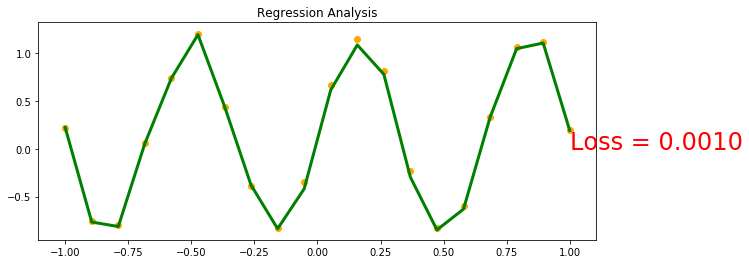

y =  0.04285385533103003 


All this took  42.07900632400015  seconds


In [140]:
# create scenario and evaluate it
start_time = time.perf_counter()

X = ex_scenario()
print('X = ', X)
y = NAS_function(X)
print('y = ', y, '\n')

#sys.exit()


print('\nAll this took ', time.perf_counter() - start_time, ' seconds')
    


In [24]:
X = ex_scenario()
active_l = 0
for param in X.keys():
    if param[:-2] == 'active':
        active_l += X[param]
        
active_l
X['active_' + str(2)]

0

In [28]:
l = [2,4,8,10,13]
for a,b in enumerate(l):
    if a:
        print(b)
    
sum(l)

4
8
10
13


37